# Package initiation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_packages')

In [2]:
from handygenome import common
from handygenome.common import ChromDict, Vcfspec, Interval
from handygenome.variantplus.breakends import Breakends
from handygenome.variantplus.variantplus import VariantPlus, VariantPlusList
from handygenome.variantplus.vcfplus import VcfPlus
from handygenome.igvhandle import IGVHandle

from handygenome.variantplus import vpfilter as libvpfilter
from handygenome.vcfeditor.initvcf import create_header

In [3]:
FASTA_PATH_HG19 = "/home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta"
FASTA_PATH_HG38 = "/home/users/data/01_reference/human_g1k_v38/Homo_sapiens_assembly38.fasta"

FASTA_HG19 = pysam.FastaFile(FASTA_PATH_HG19)
FASTA_HG38 = pysam.FastaFile(FASTA_PATH_HG38)
CHROMDICT_HG19 = ChromDict(fasta_path=FASTA_PATH_HG19)
CHROMDICT_HG38 = ChromDict(fasta_path=FASTA_PATH_HG38)

# Basic setups

In [4]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

In [5]:
BAM_PATHS = {'normal': dict(), 'tumor': dict(), 'panel': dict()}
for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype in ('tumor', 'normal', 'panel'):
                if f == f'{sampleid}.{sampletype}.bam':
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [6]:
BAMS = {sampletype: {sampleid: pysam.AlignmentFile(bampath) 
                     for sampleid, bampath in bampathdic.items()}
        for sampletype, bampathdic in BAM_PATHS.items()}

In [7]:
PANEL_REGION_GR = pr.read_bed(PANEL_REGION_PATH)

In [8]:
WHOLE_GENOME_LENGTH = 3_095_677_412
PANEL_REGION_LENGTH = 1_890_272

In [9]:
igv = IGVHandle(60387)

In [10]:
def load_bams(sampleid):
    igv.load([BAM_PATHS['normal'][sampleid], BAM_PATHS['tumor'][sampleid], BAM_PATHS['panel'][sampleid]])

In [11]:
def show_vp_igv(vp, sampleid):
    igv.cmd('new')
    igv.load([PANEL_REGION_PATH, PANEL_REGION_EXONS_PATH, PANEL_REGION_INTRONS_PATH])
    load_bams(sampleid)

    igv.goto([vp.vcfspec], width=200)
    igv.cmd('viewaspairs')
    igv.cmd('sort base')

# Find candidate variant sites

In [11]:
PANEL_VCF_INDEL_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220707_indel/02_union/panel_indel_union.annot.readstats_again.vcf.gz'

In [12]:
vcfp_indel = VcfPlus(PANEL_VCF_INDEL_PATH, set_annotdb=True, set_readstats=True, logging_lineno=1000)

[KST 2022-07-18 11:33:21 INFO] handygenome.variantplus.vcfplus: 1000 variant records processed
[KST 2022-07-18 11:33:59 INFO] handygenome.variantplus.vcfplus: 2000 variant records processed


In [13]:
fi_popfreq = libvpfilter.PopfreqFilter(cutoff=0.01, popnames=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"))
fi_diffBQ = libvpfilter.DiffMeanBQFilter(cutoff=-5)
fi_BQ = libvpfilter.AbsMeanBQFilter(cutoff=20)
fi_diffMQ = libvpfilter.DiffMeanMQFilter(cutoff=-15)
fi_MQ = libvpfilter.AbsMeanMQFilter(cutoff=40)
fi_clipovlp = libvpfilter.ClipoverlapFilter(cutoff=1)
fi_varposunif = libvpfilter.VarposUniformFilter(cutoff=0.05)
fi_readcount = libvpfilter.ReadcountFilter(cutoff=2)
fi_otherratio = libvpfilter.OthercountRatioFilter(cutoff=1.5)

ponfilter_params = {
    'deviation_cutoff': 5, 
    'subset_num_cutoff': 3, 
    'subset_fraction': 0.5,
    'germline_vaf_cutoff': 0.2,
    'germline_sample_ratio_cutoff': 0.2,
    'mode': 'mean',
}

In [14]:
def allfilter(vp, sampleid):
    fi_pon = vp.get_ponfilter(sampleids=SAMPLEIDS_LU_PANEL, **ponfilter_params)
    mask_all = all([
        fi_pon.check(vp, sampleid),
        fi_popfreq.check(vp),
        fi_diffBQ.check(vp, sampleid),
        fi_BQ.check(vp, sampleid),
        fi_diffMQ.check(vp, sampleid),
        fi_MQ.check(vp, sampleid),
        fi_clipovlp.check(vp, sampleid),
        fi_readcount.check(vp, sampleid),
        (len(vp.vcfspec.ref) >= 4 or
         fi_otherratio.check(vp, sampleid)),
    ])
    
    return mask_all

def cosmicfilter(vp):
    return vp.get_cosmic_total_occur() > 20

def readcountfilter(vp, sampleid):
    return fi_readcount.check(vp, sampleid)

def PONfilter(vp, sampleid):
    return vp.get_ponfilter(SAMPLEIDS_LU_PANEL, **ponfilter_params).check(vp, sampleid)

def functionalfilter(vp):
    return any(
        any(feature['consequence_flags'][key] for key in (
#             'is_3pUTR_involved', 
#             'is_5pUTR_involved', 
            'is_protein_altering',
        ))
        for feature in vp.annotdb.transcript_canon_ovlp.values()
    )

In [18]:
def vpfilter(vp):
    sampleid = 'LU-87_panel'
#     return functionalfilter(vp) and any(readcountfilter(vp, sampleid) for sampleid in SAMPLEIDS_LU_PANEL)
    return cosmicfilter(vp)
#     return (readcountfilter(vp, sampleid) and PONfilter(vp, sampleid))
#     return allfilter(vp, sampleid)


vcfp_indel.filter_vplist(vpfilter)
print(len(vcfp_indel.vplist_filtered))

4


In [19]:
# vp = vcfp_indel.vplist_filtered.sample()
# vplist = vcfp_indel.vplist_filtered.sample(20)
vplist = vcfp_indel.vplist_filtered

In [21]:
idx = -1

In [22]:
idx += 1
print(idx)
vp = vplist[idx]

0


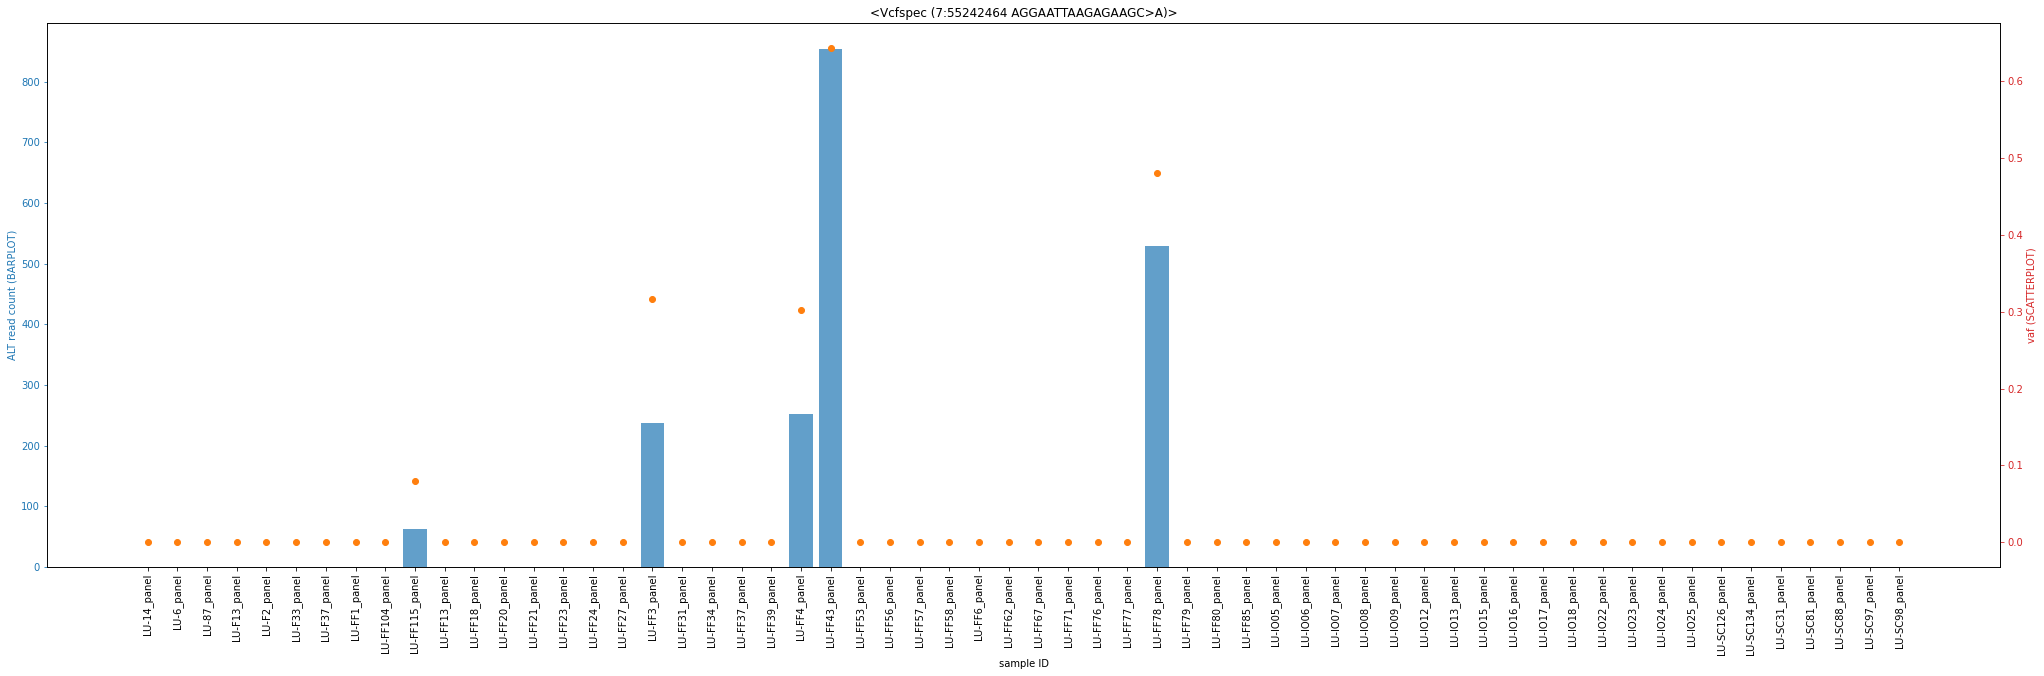

In [24]:
vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10))
# vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10), mask=mask_all)

In [25]:
sampleid = 'LU-FF43'
sampleid_panel = sampleid + '_panel'

In [26]:
show_vp_igv(vp, sampleid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


# Candidate sites

In [18]:
vcfspec = Vcfspec('15', 88593724, 'GTGTGTGTGTGTGTGTGTGTGTGTA', ('G',))
sampleid = 'LU-FF18'

In [19]:
vcfspec = '[<VariantPlus object (15	88486723	.	GC	G)>]'
sampleid = 'LU-FF18'

In [ ]:
vcfspec = '<VariantPlus object (8	32601091	.	CATATATAT	C)>'
sampleid = 'LU-FF20'

In [ ]:
vcfspec = '<VariantPlus object (17	7578503	.	CAGGGCAGGTCT	C)>'
sampleid = 'LU-FF20'

In [ ]:
# dirty region with heterogeneous softclips AKT1
vcfspec = '<VariantPlus object (14	105242405	.	CAGCAGGACTCCGCCCCCCCCA	C)>'
sampleid = 'LU-FF21'

In [ ]:
# dirty region with heterogeneous softclips CTNNB1
vcfspec = '<VariantPlus object (3	41278937	.	CAAA	C)>'
sampleid = 'LU-IO16'

In [ ]:
# ALT1/ALT2 germline het, with phasable nearby G insertion. The minor(non-germline) allele should be aligned while preserving the major(germline) alleles.
vcfspec = '<VariantPlus object (2	213316731	.	A	AG)>'
sampleid = 'LU-FF3'

In [ ]:
# ALT1/ALT2 germline het
vcfspec = '<VariantPlus object (15	88599429	.	ATATATTTT	A)>'
sampleid = 'LU-FF43'

In [ ]:
# delins reconstruction test
vcfspec = '<VariantPlus object (4	55964315	.	C	CACTT)>'
sampleid = 'LU-FF56'

In [ ]:
# delins reconstruction test
vcfspec = '<VariantPlus object (7	55242466	.	GAA	G)>'
sampleid = 'LU-FF56'

In [ ]:
vcfspec = '<VariantPlus object (2	212488828	.	G	GTC)>'
sampleid = 'LU-FF57'

In [ ]:
# multiple nearby germline variants interspersed with a somatic mutation. For genotype resolution practice.
vcfspec = '<VariantPlus object (2	212488828	.	G	GTC)>'
sampleid = 'LU-FF62_normal, LU-FF62_tumor'

In [ ]:
# to confirm pairwise2 works well with this pattern
vcfspec = '15:88408511 CC>CAA'
sampleid = 'LU-FF62'

In [ ]:
# check the VAF of deletion to the right
vcfspec = '<VariantPlus object (2	213316731	.	A	AG)>'
sampleid = 'LU-FF80'

# Code development

In [12]:
np.set_printoptions(threshold=np.inf)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [13]:
import re
        
def get_seq_specs(pileup):
    seq_specs = dict()
    for qname, row in pileup.iterrows():
        seq_spec = {
            'seq': ''.join(re.sub('[()]', '', x) for x in row
                           if x not in ('*', None)),
            'match_length': sum(x is not None for x in row),
            'left_filled': row.iloc[0] is not None,
            'right_filled': row.iloc[-1] is not None,
            'qname': qname,
        }
        seq_specs[seq_spec['qname']] = seq_spec
    return seq_specs

        
def group_seq_specs(seq_specs):
    def sortkey(seq_spec):
        return -1 * seq_spec['match_length']
#         key1 = 0 if (seq_spec['left_filled'] and seq_spec['right_filled']) else 1
#         key2 = -1 * seq_spec['match_length']
#         return (key1, key2)    
    
    def matcher(query, target):
        if query['left_filled']:
            if query['right_filled']:
                if target['left_filled'] and target['right_filled']:
                    return query['seq'] in target['seq']
                else:
                    return False
            else:
                if target['left_filled']:
                    return query['seq'] == target['seq'][:len(query['seq'])]
                else:
                    return False
        else:
            if query['right_filled']:
                if target['right_filled']:
                    return query['seq'] == target['seq'][-len(query['seq']):]
                else:
                    return False
            else:
                return query['seq'] in target['seq']                
        
    result = dict()
    for query in sorted(seq_specs.values(), key=sortkey):
        superseq_candidates = list()
        for qname in result.keys():
            target = seq_specs[qname]
            if matcher(query, target):
                superseq_candidates.append(qname)
                
        if len(superseq_candidates) == 0:                
            result[query['qname']] = list()
            result[query['qname']].append(query)
        else:
            superseq_qname = max(superseq_candidates, key=(lambda qname: seq_specs[qname]['match_length']))
            result[superseq_qname].append(query)
            
    return result

In [14]:
tbam = BAMS['tumor']['LU-FF43']
tbam_path = BAM_PATHS['tumor']['LU-FF43']
nbam = BAMS['normal']['LU-FF43']
nbam_path = BAM_PATHS['normal']['LU-FF43']

vcfspec = Vcfspec('7', 55_242_464, 'A', ('G',))
# intv = Interval(chrom='7', start1=55_242_464, end1=55_242_480)
intv = Interval(chrom='7', start1=55_242_464, end1=55_242_480)
bam = tbam

# readlist = list(BAMS['normal']['LU-FF43'].fetch(vcfspec.chrom, vcfspec.pos0, vcfspec.end0))
# readlist = list(BAMS['tumor']['LU-FF43'].fetch(vcfspec.chrom, vcfspec.pos0, vcfspec.end0))
# readlist = list(tbam.fetch(intv.chrom, intv.start0, intv.end0))

In [15]:
igv.load([tbam_path, nbam_path])
igv.goto([vcfspec], width=100)

OK
OK
OK


In [16]:
from handygenome.align import realign
from handygenome.readplus import readhandler

active_range = realign.get_active_range(bam, intv.chrom, intv.start0, intv.end0, threshold=0.9, inactive_padding=30, add_pileup_by=10)
pileup, readlist = readhandler.get_pileup(bam, intv.chrom, active_range.start, active_range.stop, as_array=False, truncate=True, with_readlist=True, append_read12_to_qname=True)

seq_specs = get_seq_specs(pileup)
seq_spec_groups = group_seq_specs(seq_specs)

In [17]:
print(active_range)

range(55242434, 55242510)


In [397]:
for qname in seq_spec_groups.keys():
    pprint.pprint(seq_specs[qname])

{'left_filled': True,
 'match_length': 76,
 'qname': 'ST-E00129:825:HVYFNCCXY:6:1204:23734:35256_read2',
 'right_filled': True,
 'seq': 'TGAGAAAGTTAAAATTCCCGTCGCTATCAAAACATCTCCGAAAGCCAACAAGGAAATCCTC'}
{'left_filled': True,
 'match_length': 76,
 'qname': 'ST-E00129:825:HVYFNCCXY:5:2120:25449:14142_read2',
 'right_filled': True,
 'seq': 'TGAGAAAGTTAAAATTCCCGTCGCTATCAAGGAATTAAGAGAAGCAACATCTCCGAAAGCCAACAAGGAAATCCTC'}
{'left_filled': True,
 'match_length': 76,
 'qname': 'ST-E00129:825:HVYFNCCXY:5:2204:24393:26835_read2',
 'right_filled': True,
 'seq': 'TGAGAAAGTTAAAATTCTCGTCGCTATCAAAACATCCCCGAAAGCCAAAAAGGAAATCCTC'}
{'left_filled': True,
 'match_length': 76,
 'qname': 'ST-E00129:825:HVYFNCCXY:6:2214:24302:58919_read1',
 'right_filled': True,
 'seq': 'TGAGAAAGTTAAAATTCCCGTCGCTATCTAGGAATTAAGAGAAGCAACATCTCCGAAAGCCAACAAGGAAATCCTC'}
{'left_filled': True,
 'match_length': 43,
 'qname': 'ST-E00129:825:HVYFNCCXY:6:2104:1610:19786_read2',
 'right_filled': False,
 'seq': 'TGAGAAAGTTAAAATTCCCGTCGCTATCA

In [420]:
counts = dict()
for qname, group in seq_spec_groups.items():
    counts[seq_specs[qname]['seq']] = len(group)
    

In [422]:
for key, val in counts.items():
    print(key, round(val / sum(counts.values()), 3))

TGAGAAAGTTAAAATTCCCGTCGCTATCAAAACATCTCCGAAAGCCAACAAGGAAATCCTC 0.723
TGAGAAAGTTAAAATTCCCGTCGCTATCAAGGAATTAAGAGAAGCAACATCTCCGAAAGCCAACAAGGAAATCCTC 0.214
TGAGAAAGTTAAAATTCTCGTCGCTATCAAAACATCCCCGAAAGCCAAAAAGGAAATCCTC 0.006
TGAGAAAGTTAAAATTCCCGTCGCTATCTAGGAATTAAGAGAAGCAACATCTCCGAAAGCCAACAAGGAAATCCTC 0.006
TGAGAAAGTTAAAATTCCCGTCGCTATCAAGGAATTAAGAGAN 0.006
AACACCACCCAGAATACCCGGGCACCTGTCGGCACATTCCCCCAATGCCCGGTAAGCGTCTCCTTCTCTCTTCGGCAATCGGGACTTTGTGTCCCAAAAGGTACGAAAGTAAAATTCCCGTCGCTATCAAGGAATTAAGAGAAGCAACATC 0.006
TGAGAAAGTTAAAATTCCCGTCGCTCTCAAGGAA 0.006
TGAGAAAGTTAAAATTCCCGTCGCTATCAAAACATCGCCGAAAGCCA 0.006
TGAGAAAGTTAAAAGTCCCG 0.006
ACGCCAACAAGGAAATCCTC 0.006
AAGGAAACCCTC 0.006
AGATCCTC 0.006


In [395]:
import Bio.Align
import Bio.Seq
from handygenome.align import pairwise

aligner = Bio.Align.PairwiseAligner(
    mode='global',
match_score=2,
mismatch_score=-3,
query_internal_open_gap_score=-7,
query_internal_extend_gap_score=-2,
target_internal_open_gap_score=-7,
target_internal_extend_gap_score=-2,
query_left_open_gap_score=-7,
query_left_extend_gap_score=-2,
)


In [413]:
target = FASTA_HG19.fetch(intv.chrom, active_range.start, active_range.stop)
query = 'AGATCCTC'

In [417]:
# alns = aligner.align(target, query)
alns = aligner.align(target[::-1], query[::-1])

In [418]:
aln = alns[0]
print(aln)
print(aln.format('sam'))
print(aln.score)

CTCCTAAAGGAACAACCGAAAGCCTCTACAACGAAGAGAATTAAGGAACTATCGCTGCCCTTAAAATTGAAAGAGT
||||||.|--------------------------------------------------------------------
CTCCTAGA--------------------------------------------------------------------

query	0	target	1	255	8M	*	0	0	CTCCTAGA	*	AS:i:11

11.0


In [363]:
from handygenome.align import bwa

seqlist = list()
namelist = list()
for qname in seq_spec_groups.keys():
    seqlist.append(seq_specs[qname]['seq'])
    namelist.append(qname)
    
bwa_result = bwa.run_bwa(seqlist=seqlist, refver='hg19', namelist=namelist)

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 12 sequences (609 bp)...
[M::mem_process_seqs] Processed 12 reads in 0.008 CPU sec, 0.018 real sec
[main] Version: 0.7.17-r1188
[main] CMD: /home/users/pjh/scripts/python_genome_packages/utils/bwa mem -Y -M -t 1 -o /home/users/pjh/scripts/python_genome_packages/tests/tmpgmmpngfh/output.sam /home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta /home/users/pjh/scripts/python_genome_packages/tests/tmpgmmpngfh/input.fasta
[main] Real time: 10.322 sec; CPU: 6.612 sec


In [364]:
for read in bwa_result:
    print(read.to_string())

ST-E00129:825:HVYFNCCXY:6:1204:23734:35256_read2	0	7	55242435	41	30M15D31M	*	0	0	TGAGAAAGTTAAAATTCCCGTCGCTATCAAAACATCTCCGAAAGCCAACAAGGAAATCCTC	*	NM:i:15	MD:Z:30^GGAATTAAGAGAAGC31	AS:i:40	XS:i:0
ST-E00129:825:HVYFNCCXY:5:2120:25449:14142_read2	0	7	55242435	60	76M	*	0	0	TGAGAAAGTTAAAATTCCCGTCGCTATCAAGGAATTAAGAGAAGCAACATCTCCGAAAGCCAACAAGGAAATCCTC	*	NM:i:0	MD:Z:76	AS:i:76	XS:i:20
ST-E00129:825:HVYFNCCXY:5:2204:24393:26835_read2	4	*	0	0	*	*	0	0	TGAGAAAGTTAAAATTCTCGTCGCTATCAAAACATCCCCGAAAGCCAAAAAGGAAATCCTC	*	AS:i:0	XS:i:0
ST-E00129:825:HVYFNCCXY:6:2214:24302:58919_read1	0	7	55242435	60	76M	*	0	0	TGAGAAAGTTAAAATTCCCGTCGCTATCTAGGAATTAAGAGAAGCAACATCTCCGAAAGCCAACAAGGAAATCCTC	*	NM:i:1	MD:Z:28A47	AS:i:71	XS:i:19
ST-E00129:825:HVYFNCCXY:6:2104:1610:19786_read2	0	7	55242435	60	43M	*	0	0	TGAGAAAGTTAAAATTCCCGTCGCTATCAAGGAATTAAGAGAN	*	NM:i:1	MD:Z:42A0	AS:i:42	XS:i:0
ST-E00129:825:HVYFNCCXY:8:1209:23551:59200_read1	0	7	55242444	60	109S42M	*	0	0	AACACCACCCAGAATACCCGGGCACCTGTCGGCACATTCCCCCAATGCCCGGTAAGCGT